Are the contaminants being injected into the water column within the Salish Sea Atlantis Model within a timescale of 10 days as we might expect? 

How about uptake by the phytoplankton?

### Highres Tests
- v6699_16 - updated code version (see SSAM-output-biopools.ipynb)
- v6699_17 - updated code version + small number dummy contaminant file to zero out contaminants, but flag_dissolved_pollutants = 0
- highres3 - reduced uptake rates of PAH for diatoms and picos to around 8.0e-03 mg/m^3 per day
- v6699_17A - flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 1
- v6699_17B - flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 0
- v6699_18 - bm->dayt in decay calculation, flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 0
- v6699_18B - removed (/time_step) so that sp_amount_decayed = cGroupLevel - newValue
- v6699_18C - test to see if 18B still works if time_step = dt rather than dayt.
- v6699_18D - put time_step back to dt, but in atContaminants.c line 1094, instead of using cLevel in Calculate_Species_Contaminant_Decay, defined cGroupLevel = tracerArray[FunctGroupArray[sp].contaminantTracers[cohort][cIndex]]; and then defined the tracerArray as getTracerArray(boxLayerInfo, habitat) except for EPIFAUNA (getTracerArray(boxLayerInfo, WC))
- v6699_18E - added a decay_constant defined by the half-life, and defined the new_value = cGroupLevel * decay_constant * time_step;
- v6699_18F - tracerArray = getTracerArray(boxLayerInfo, habitat); left off bit about epifauna as it crashed the longer runs.
- v6699_18G - return half_life equation to original while leaving other changes
- v6699_19A - remove ability of contaminants pass from detritus to bio through predation + turned on flag_dissolved_pollutants
- v6699_20 - remove ability of contaminants to pass back to the water column

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

### Package and file imports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from PIL import Image
import glob
from IPython.display import Image as img
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
control_name = 'v6699_20_highres_single_injection'
test_name = 'v6699_20_highres_single_injection_phytop'
test2_name = 'v6699_20_highres_single_injection_prop'
#test3_name = 'v6699_20_highres_B'
#labels = [control_name,test_name,test2_name, test3_name]
#testlabels = [test_name, test2_name, test3_name]

In [3]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [4]:
time_c = np.ma.filled(control.variables['t'], np.nan)

In [5]:
test_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_" + test_name + "/outputSalishSea.nc"
test2_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_" + test2_name + "/outputSalishSea.nc"
test = xr.open_dataset(str(test_path), decode_cf=True)
test2= xr.open_dataset(str(test2_path), decode_cf=True)

In [ ]:
test3_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/Test_Scenario_5b_" + test3_name + "/outputSalishSea.nc"
test3= xr.open_dataset(str(test3_path), decode_cf=True)

In [6]:
time = np.ma.filled(test.variables['t'], np.nan)

In [7]:
scenarios = [control, test, test2]
scens = [test, test2]
#scen3 = [test3]
cont = [control]

In [8]:
labels = ['unmodified uptake + transfer','phytop uptake only + transfer','prop-code modified']
testlabels = ['unmodified, phytop uptake only','prop-code modified']

In [9]:
def plot_pah(scenario, times, label):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

### Water Column - without resets

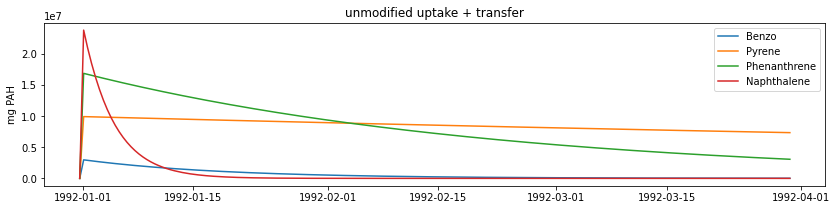

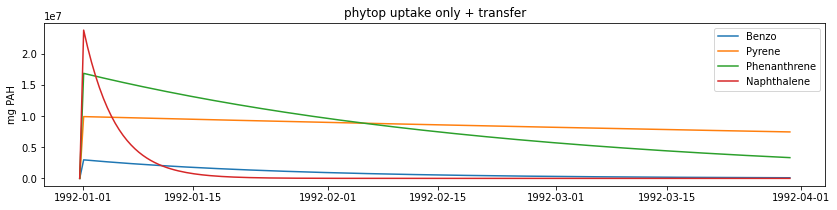

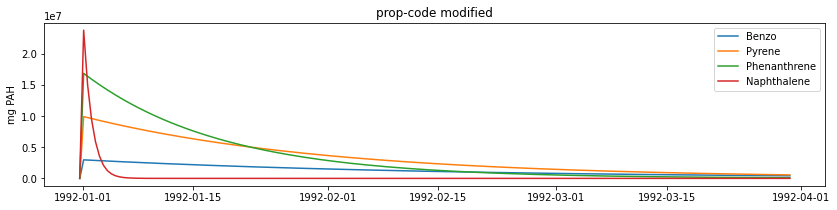

In [10]:
for test, name in zip (scenarios, labels):
    plot_pah(test, time, label=name)

### Detritus

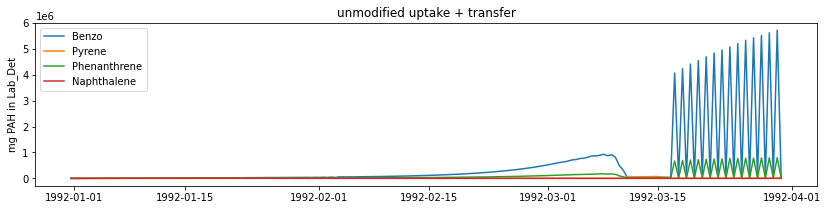

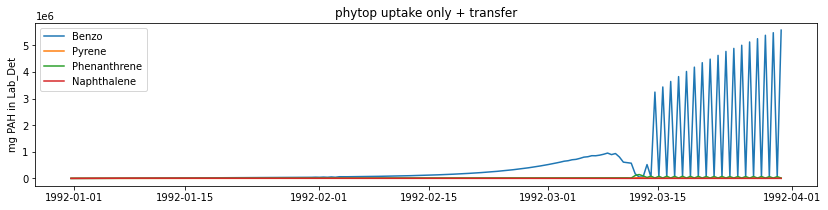

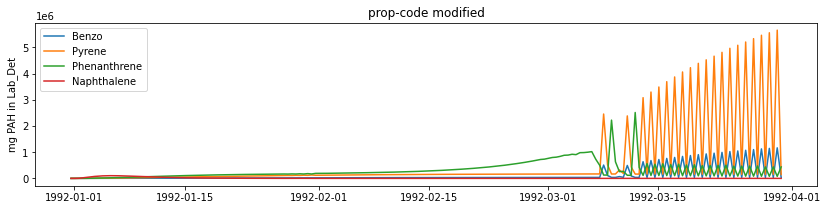

In [11]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Lab_Det_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Lab_Det')
    ax.set_title(label);

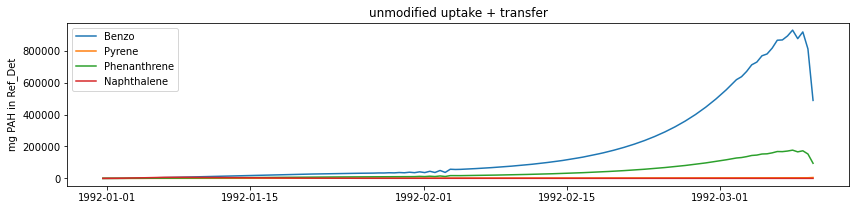

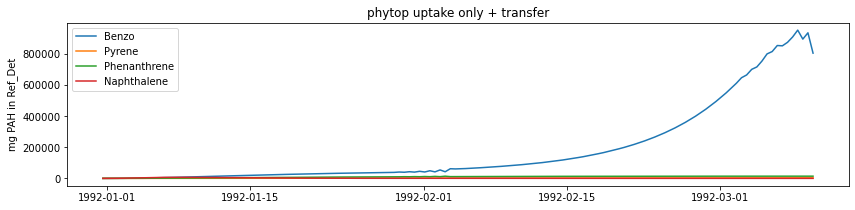

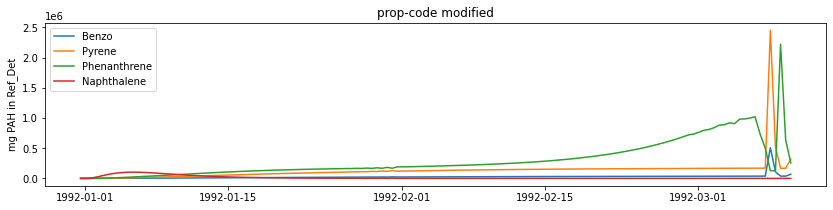

In [12]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Lab_Det_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time[0:140], contam_mass_t[0:140])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Ref_Det')
    ax.set_title(label);

In [13]:
for scenario, label in zip(scenarios, labels):
    for pah in groups.pahs:
        name = 'Ref_Det_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        max_contam_mass = contam_mass_t.max()
        print(label, name, max_contam_mass)

unmodified uptake + transfer Ref_Det_Benzo 32102610.75499
unmodified uptake + transfer Ref_Det_Pyrene 386071.8851198869
unmodified uptake + transfer Ref_Det_Phenanthrene 4434499.606459454
unmodified uptake + transfer Ref_Det_Naphthalene 4298.825711352178
phytop uptake only + transfer Ref_Det_Benzo 31199320.80487426
phytop uptake only + transfer Ref_Det_Pyrene 124770.1593582394
phytop uptake only + transfer Ref_Det_Phenanthrene 3341142.7245040787
phytop uptake only + transfer Ref_Det_Naphthalene 4030.458474002807
prop-code modified Ref_Det_Benzo 6382063.952881
prop-code modified Ref_Det_Pyrene 31105079.84328293
prop-code modified Ref_Det_Phenanthrene 13555600.702620907
prop-code modified Ref_Det_Naphthalene 13547.16922086459


Maximum Ref_Det Benzo mass is 594% of total Benzo injected

In [78]:
for scenario, label in zip(scenarios, labels):
    for pah in groups.pahs:
        name = 'Lab_Det_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        max_contam_mass = contam_mass_t.max()
        print(label, name, max_contam_mass)

single injection, uptake + transfer Lab_Det_Naphthalene 6887.5181522899065
single injection, uptake + transfer Lab_Det_Pyrene 72424.73969387297
single injection, uptake + transfer Lab_Det_Phenanthrene 798407.3155277756
single injection, uptake + transfer Lab_Det_Benzo 5722666.927022861
single injection, phytop uptake only + transfer Lab_Det_Naphthalene 6884.815007152324
single injection, phytop uptake only + transfer Lab_Det_Pyrene 25691.647004830927
single injection, phytop uptake only + transfer Lab_Det_Phenanthrene 144748.2206578485
single injection, phytop uptake only + transfer Lab_Det_Benzo 5572956.425691156
single injection, zoop uptake only + transfer Lab_Det_Naphthalene 6.939875402911981
single injection, zoop uptake only + transfer Lab_Det_Pyrene 110.33369565043266
single injection, zoop uptake only + transfer Lab_Det_Phenanthrene 113087.44629511646
single injection, zoop uptake only + transfer Lab_Det_Benzo 15136.659421649434


Maximum Lab_det Benzo mass is 106% of total Benzo injected

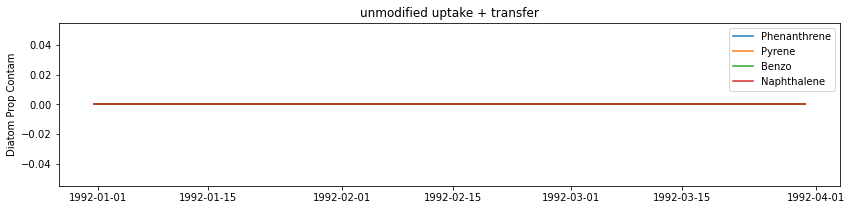

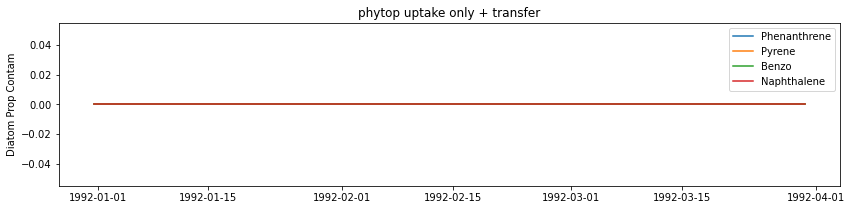

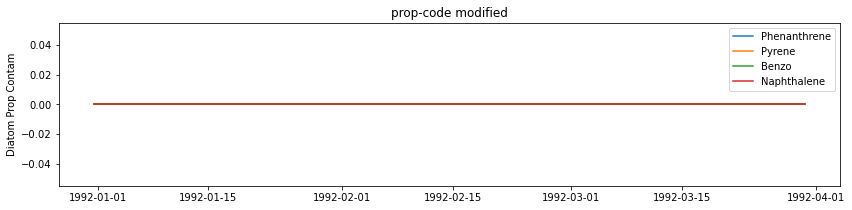

In [15]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Lab_Det_Prop_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        #volume_tbl = np.ma.filled(scenario.volume, np.nan)
        #contam_mass_tbl = contam_tbl * volume_tbl
        contam_tb = contam_tbl.sum(axis=2)
        contam_t = contam_tb.sum(axis=1)

        ax.plot(time, contam_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('Diatom Prop Contam')
    ax.set_title(label);

### Phytoplankton proportion with PAH

In [14]:
for scenario, label in zip(scenarios, labels):
    for pah in groups.pahs:
        mass = 0
        for species in ['PicoPhytopl','Diatom', 'Carniv_Zoo', 'Gelat_Zoo', 'MicroZoo','Zoo','Pelag_Bact','Squid','Prawn']:    
            name = species + '_' + pah
            contam_tbl = np.ma.filled(scenario.variables[name][:,:,0:6], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            mass = mass + contam_mass_t
        max_contam_mass = mass.max()
        print(label, pah, max_contam_mass)

unmodified uptake + transfer Benzo 2281572.1243842808
unmodified uptake + transfer Pyrene 258512.22789387414
unmodified uptake + transfer Phenanthrene 797928.541665143
unmodified uptake + transfer Naphthalene 948962.7555780244
phytop uptake only + transfer Benzo 2123302.7950497675
phytop uptake only + transfer Pyrene 169540.8737978453
phytop uptake only + transfer Phenanthrene 561951.828707237
phytop uptake only + transfer Naphthalene 637632.6255754705
prop-code modified Benzo 1583833.9503438019
prop-code modified Pyrene 6818152.839621246
prop-code modified Phenanthrene 7034891.039853821
prop-code modified Naphthalene 11325052.074700247


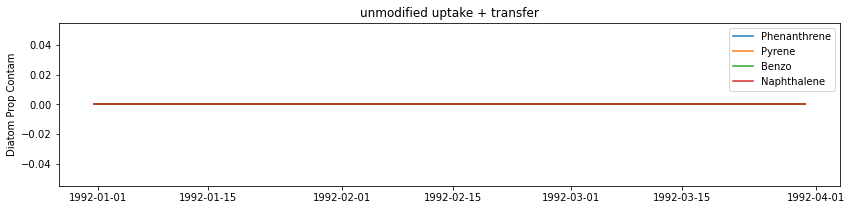

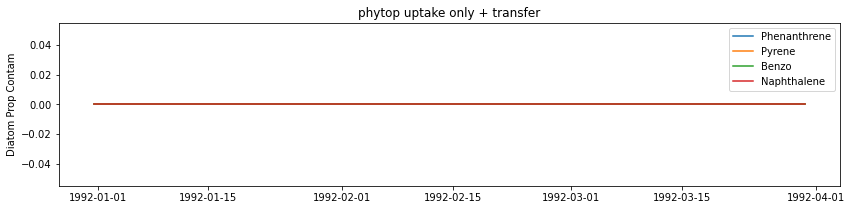

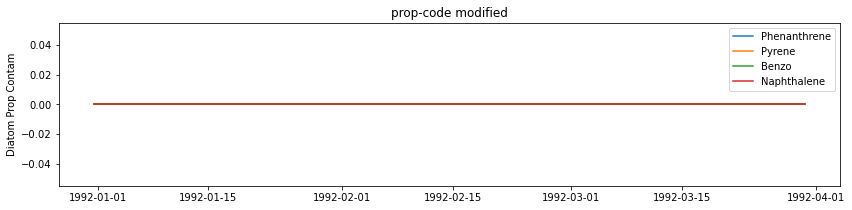

In [14]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Diatom_Prop_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        #volume_tbl = np.ma.filled(scenario.volume, np.nan)
        #contam_mass_tbl = contam_tbl * volume_tbl
        contam_tb = contam_tbl.sum(axis=2)
        contam_t = contam_tb.sum(axis=1)

        ax.plot(time, contam_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('Diatom Prop Contam')
    ax.set_title(label);

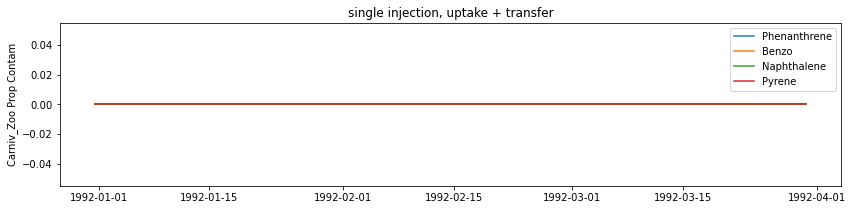

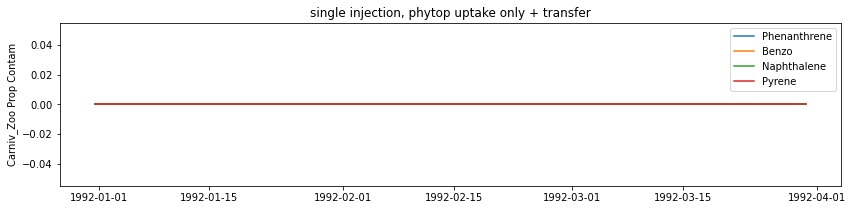

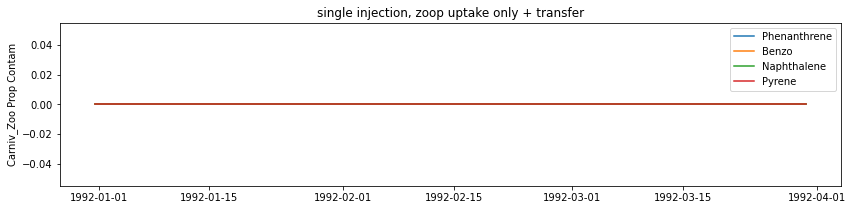

In [12]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Carniv_Zoo_Prop_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        #volume_tbl = np.ma.filled(scenario.volume, np.nan)
        #contam_mass_tbl = contam_tbl * volume_tbl
        contam_tb = contam_tbl.sum(axis=2)
        contam_t = contam_tb.sum(axis=1)

        ax.plot(time, contam_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('Carniv_Zoo Prop Contam')
    ax.set_title(label);

### Pelagic Bacteria

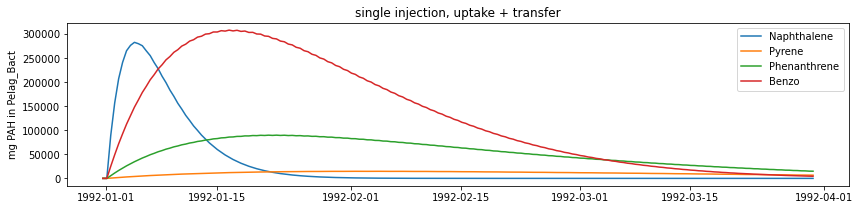

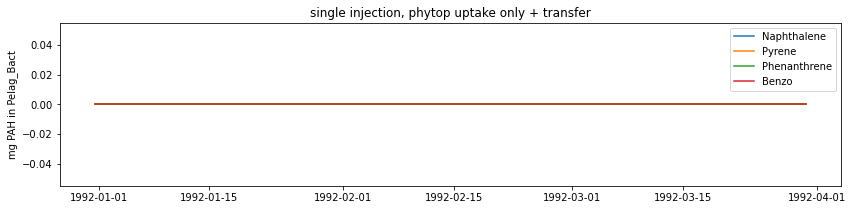

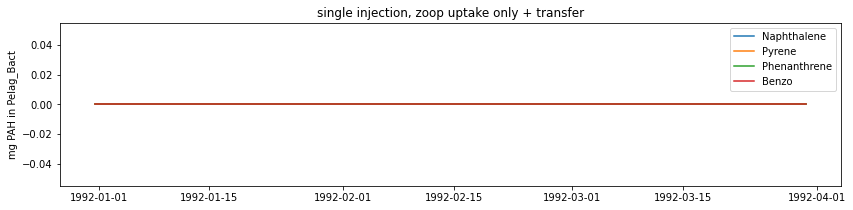

In [31]:
for scenario, label in zip(scenarios, labels):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        name = 'Pelag_Bact_' + pah
        contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(time, contam_mass_t[0:time.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH in Pelag_Bact')
    ax.set_title(label);